# Imports and data

In [216]:
import requests
import json
from datetime import datetime, timedelta
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pmdarima.arima import auto_arima

import pickle

from IPython.display import display

In [2]:
raw_data = pd.read_csv('data/ods032.csv', delimiter=';')

In [3]:
data = raw_data.copy()
data['Datetime'] = pd.to_datetime(data['Datetime'], utc=True)
data.set_index("Datetime", inplace=True)
data = data.sort_index()

In [270]:
display(data.tail())
# display(data.describe(include='all'))

,Resolution code,Region,Measured & Upscaled,Most recent forecast,Most recent P10,Most recent P90,Day Ahead 11AM forecast,Day Ahead 11AM P10,Day Ahead 11AM P90,Day-ahead 6PM forecast,Day-ahead 6PM P10,Day-ahead 6PM P90,Week-ahead forecast,Week-ahead P10,Week-ahead P90,Monitored capacity,Load factor
Datetime,,,,,,,,,,,,,,,,,
2018-08-31 22:00:00+00:00,PT15M,Luxembourg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,98.169,0.0
2018-08-31 22:00:00+00:00,PT15M,Flanders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,2387.455,0.0
2018-08-31 22:00:00+00:00,PT15M,East-Flanders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,551.989,0.0
2018-08-31 22:00:00+00:00,PT15M,West-Flanders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,536.622,0.0
2018-08-31 22:00:00+00:00,PT15M,Brussels,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,48.975,0.0


In [271]:
# data_2023 = data.loc['2023-01-01':'2023-12-31']
# data_2023.isnull().sum()
# data_2023 = data_2023.dropna()
# display(data_2023.describe(include='all'))
# display(data_2023.head())
# display(data_2023.tail())

In [9]:
data[data['Measured & Upscaled']>10].head()

,Datetime,Resolution code,Region,Measured & Upscaled,Most recent forecast,Most recent P10,Most recent P90,Day Ahead 11AM forecast,Day Ahead 11AM P10,Day Ahead 11AM P90,Day-ahead 6PM forecast,Day-ahead 6PM P10,Day-ahead 6PM P90,Week-ahead forecast,Week-ahead P10,Week-ahead P90,Monitored capacity,Load factor
280,2024-10-01 16:45:00+00:00,PT15M,Flemish-Brabant,12.686,11.573,6.973,16.380,3.834,0.864,7.315,6.867,1.307,11.049,8.280,6.716,18.927,1021.541,1.242
282,2024-10-01 16:45:00+00:00,PT15M,Wallonia,27.270,26.624,14.069,39.509,10.538,3.155,20.730,17.239,5.174,28.464,15.882,11.521,46.898,2376.313,1.148
283,2024-10-01 16:45:00+00:00,PT15M,Flanders,66.432,75.256,49.434,108.425,32.216,7.308,63.454,48.147,8.047,78.752,80.921,44.629,164.336,7694.338,0.863
286,2024-10-01 16:45:00+00:00,PT15M,Belgium,97.882,105.649,65.622,153.498,43.874,10.710,86.529,67.309,13.628,110.301,99.455,58.441,216.587,10395.707,0.942
287,2024-10-01 16:45:00+00:00,PT15M,Limburg,15.517,10.268,5.490,15.304,4.295,1.044,7.956,8.091,2.027,13.975,6.505,4.927,24.875,1405.422,1.104


In [10]:
data.Region.unique()

array(['Flanders', 'Limburg', 'Wallonia', 'Belgium', 'West-Flanders',
       'Luxembourg', 'Hainaut', 'Namur', 'East-Flanders',
       'Flemish-Brabant', 'Walloon-Brabant', 'Brussels', 'Antwerp',
       'Liège'], dtype=object)

# Graphing


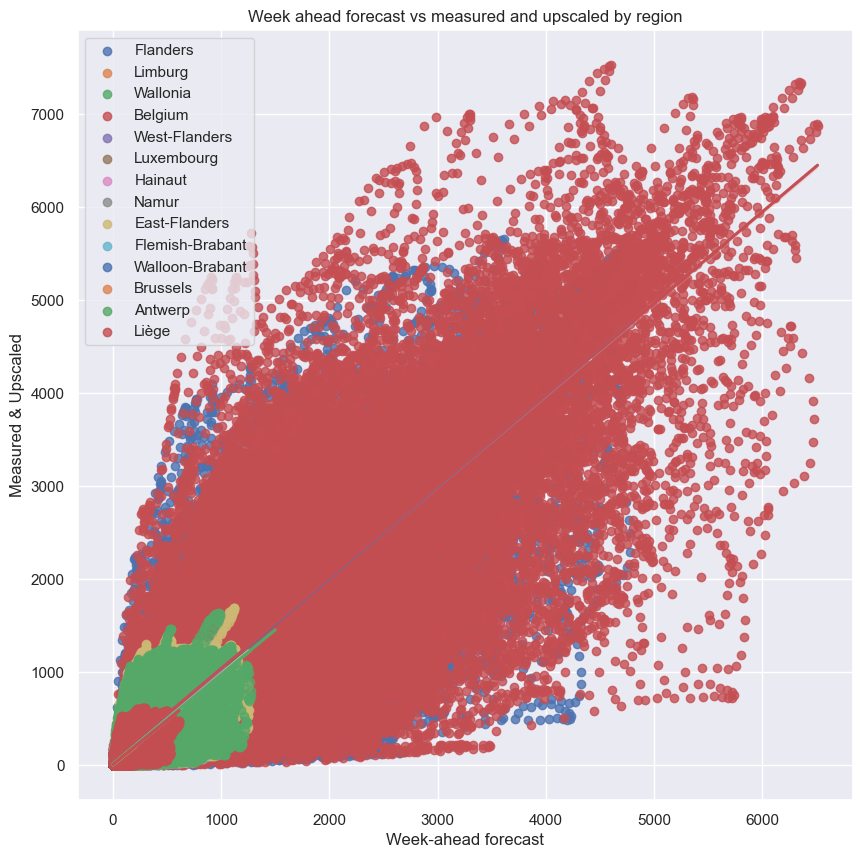

In [10]:
plt.figure(figsize=(10, 10))
plt.title('Week ahead forecast vs measured and upscaled by region')
for region in data['Region'].unique():
    ax = sns.regplot(data[data['Region']==region], y='Measured & Upscaled', x='Week-ahead forecast', label=region)
plt.legend()
plt.show()

Flanders
Limburg
Wallonia
Belgium
West-Flanders
Luxembourg
Hainaut
Namur
East-Flanders
Flemish-Brabant
Walloon-Brabant
Brussels
Antwerp
Liège


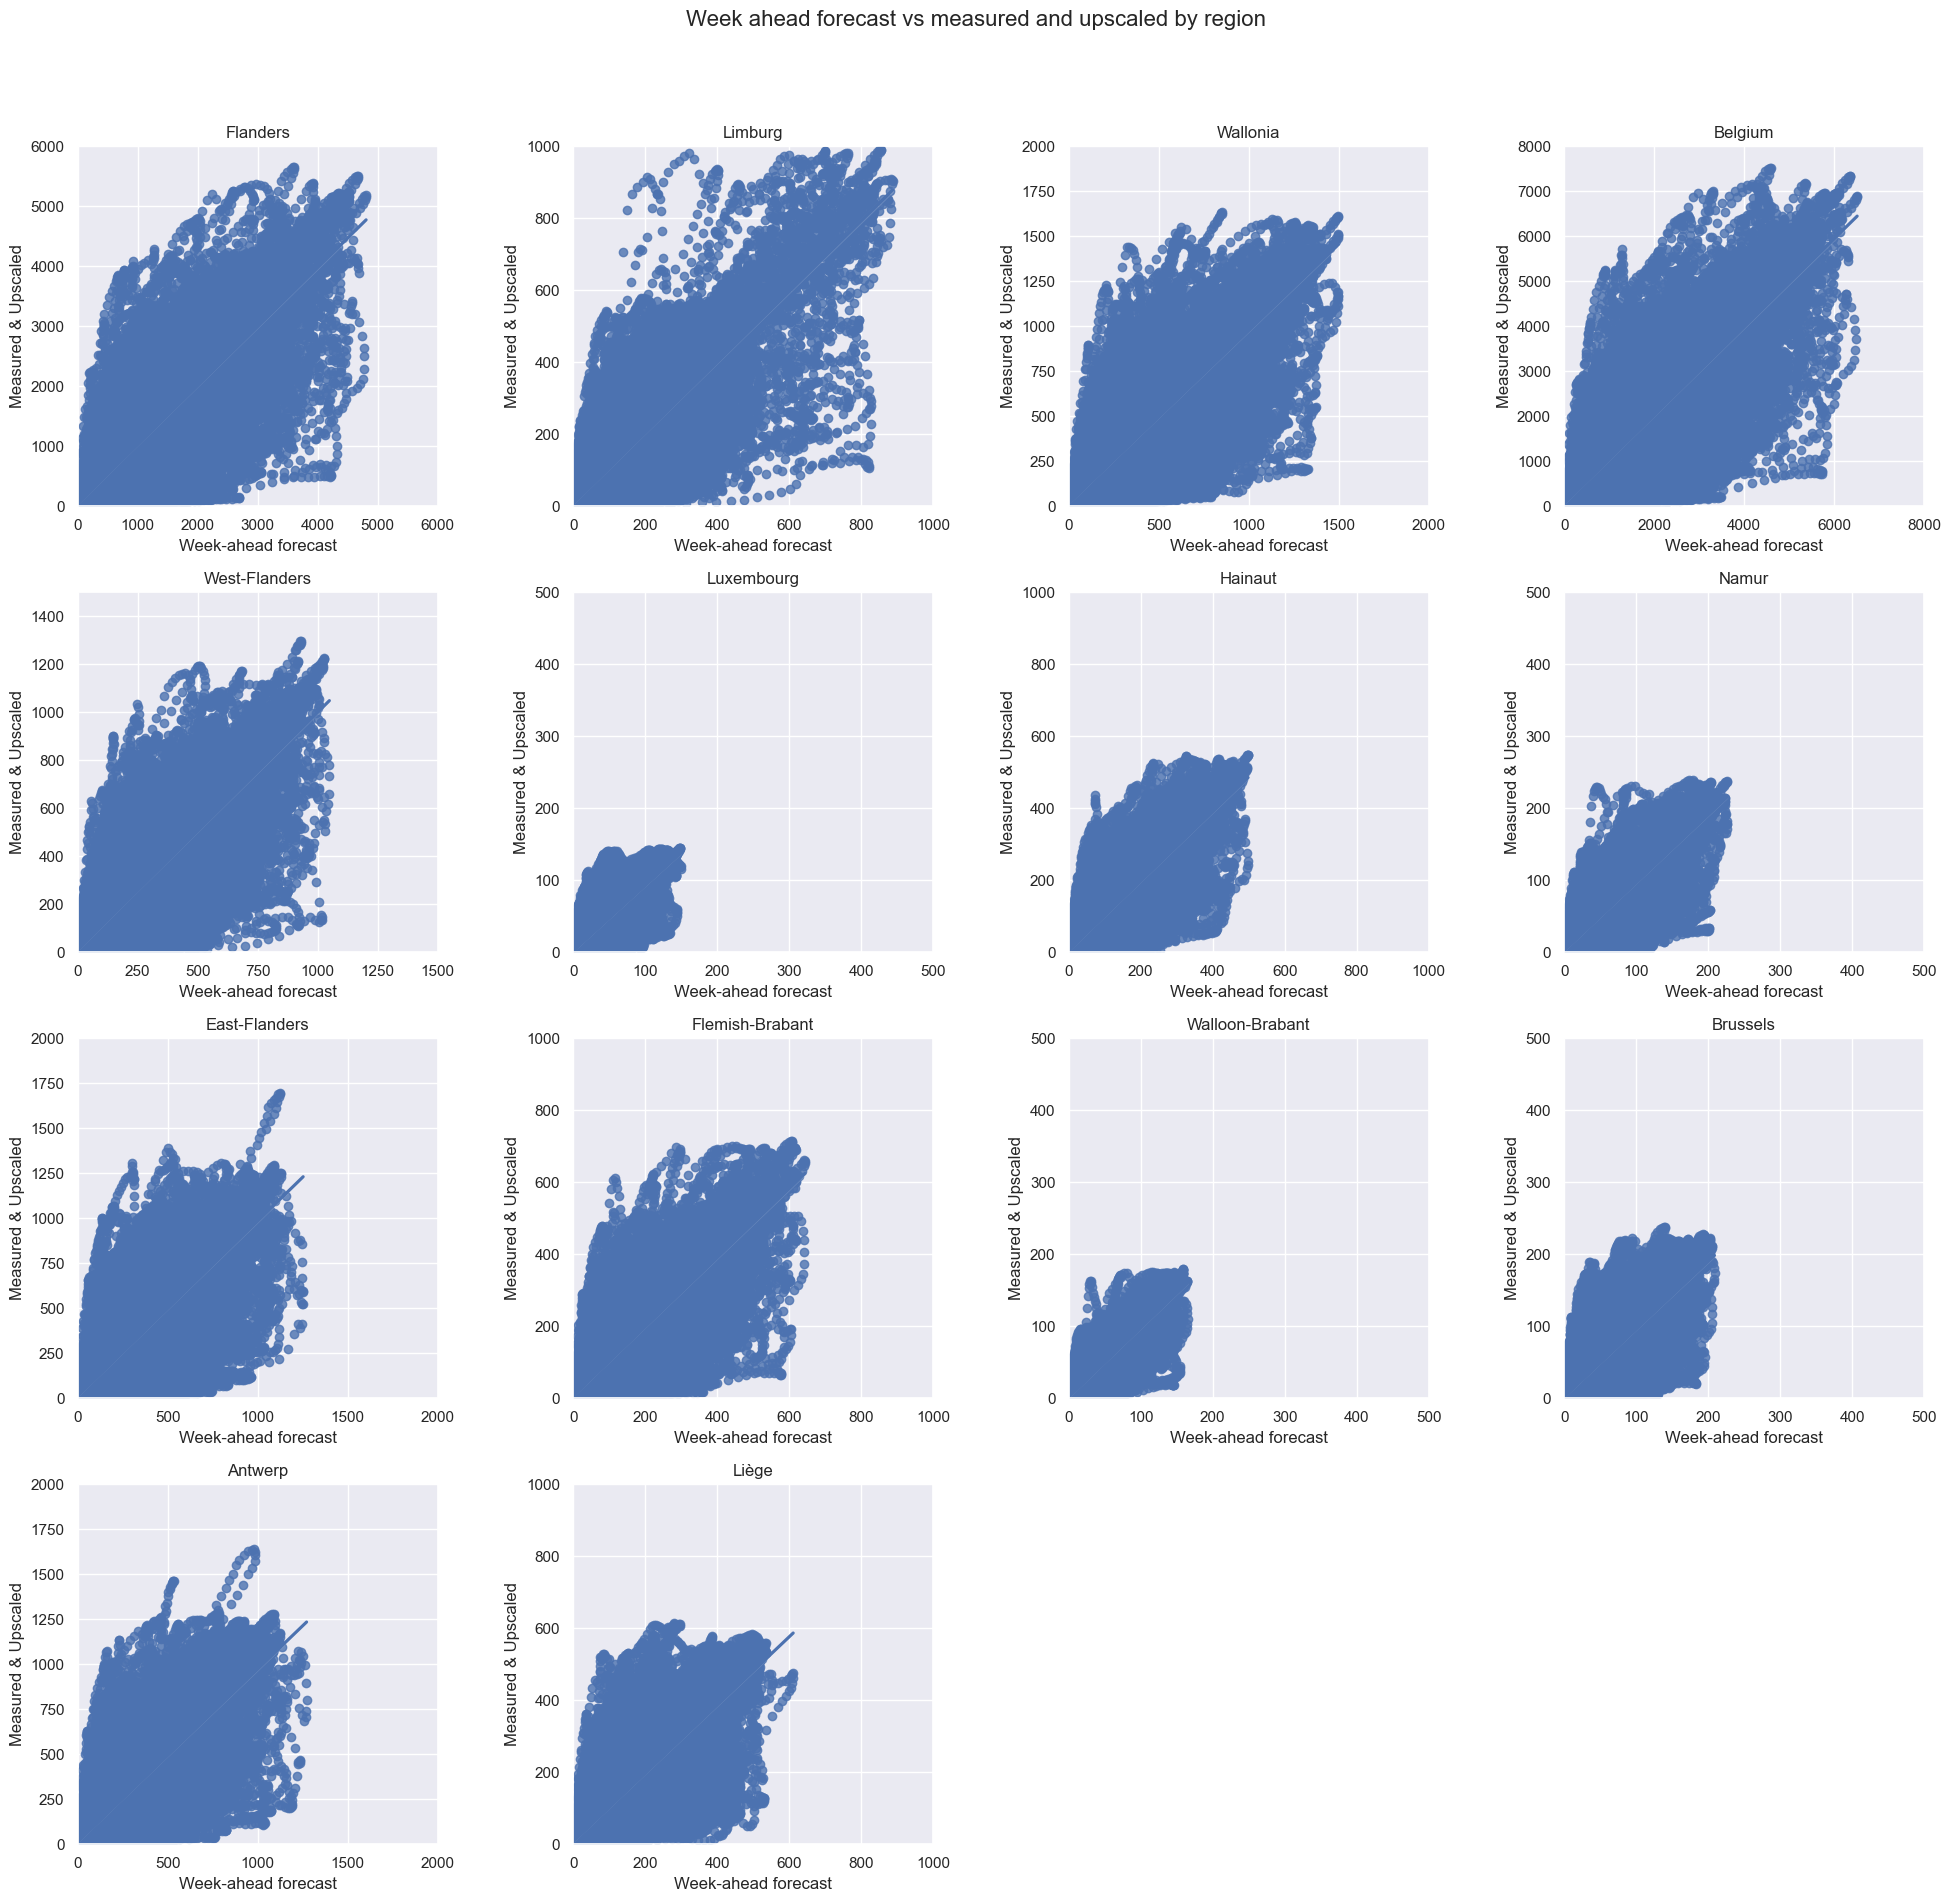

In [31]:
plt.figure(figsize=(20, 20))
plt.suptitle('Week ahead forecast vs measured and upscaled by region', fontsize=16)

regions = data['Region'].unique()
rows, cols = 4, 4

for i, region in enumerate(regions, 1):
    print(region)
    ax = plt.subplot(rows, cols, i)
    region_data = data[data['Region'] == region]
    
    max_value = max(
        region_data['Week-ahead forecast'].max(),
        region_data['Measured & Upscaled'].max()
    )
    max_limit = np.ceil(max_value / 500) * 500
    
    sns.regplot(data=region_data, 
                x='Week-ahead forecast', 
                y='Measured & Upscaled')
    plt.title(region)
    plt.xlabel('Week-ahead forecast')
    plt.ylabel('Measured & Upscaled')
    
    ax.set_xlim(0, max_limit)
    ax.set_ylim(0, max_limit)
    
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

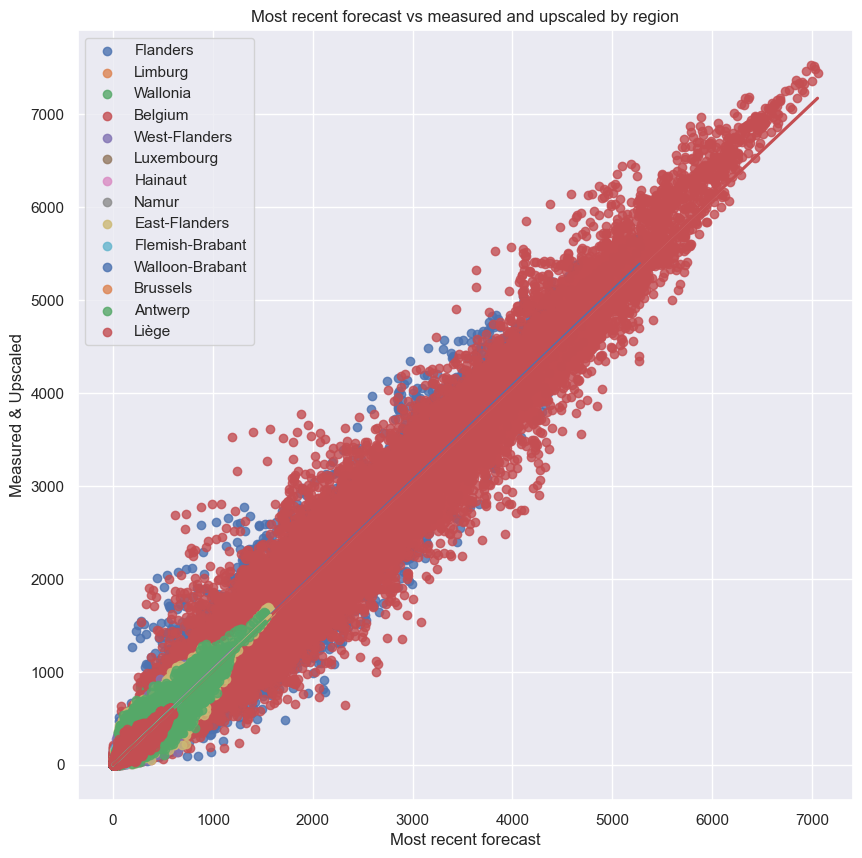

In [11]:
plt.figure(figsize=(10, 10))
plt.title('Most recent forecast vs measured and upscaled by region')
for region in data['Region'].unique():
    ax = sns.regplot(data[data['Region']==region], y='Measured & Upscaled', x='Most recent forecast', label=region)
plt.legend()
plt.show()

# Errors vs Measured 

In [133]:
# df = data_2023[data_2023.Region == 'Belgium'].copy()
df = data_2023[['Region','Week-ahead forecast','Most recent forecast','Measured & Upscaled']]
df = df[df['Measured & Upscaled'] != 0]

df['Week Error'] = df['Measured & Upscaled'] - df['Week-ahead forecast']
df['Week Percentage Error'] = np.divide(
    df['Week Error'],
    df['Measured & Upscaled'],
    out=np.zeros_like(df['Week Error']),
    where=df['Measured & Upscaled'] != 0
) * 100
df['Week Percentage Error'] = df['Week Percentage Error'].round(1)

df['Recent Error'] = df['Measured & Upscaled'] - df['Most recent forecast']
df['Recent Percentage Error'] = np.divide(
    df['Recent Error'],
    df['Measured & Upscaled'],
    out=np.zeros_like(df['Recent Error']),
    where=df['Measured & Upscaled'] != 0
) * 100
df['Recent Percentage Error'] = df['Recent Percentage Error'].round(1)

df = df[['Region','Measured & Upscaled', 'Week-ahead forecast', 'Week Error', 'Week Percentage Error', 'Most recent forecast', 'Recent Error', 'Recent Percentage Error']]
df = df.rename(columns={
    'Measured & Upscaled': 'Actual',
    'Week-ahead forecast': 'Week',
    'Week Error': 'Week_Err',
    'Week Percentage Error': 'Week_%',
    'Most recent forecast': 'Recent',
    'Recent Error': 'Recent_Err',
    'Recent Percentage Error': 'Recent_%'
})

In [156]:
mean_errors = []

for i, region in enumerate(df.Region.unique()):
    region_data = df[df['Region'] == region]
    week_mean = int(region_data['Week_%'].mean())
    recent_mean = int(region_data['Recent_%'].mean())
    mean_errors.append({'Region': region, 'Week': week_mean, 'Most Recent': recent_mean})

mean_errors_df = pd.DataFrame(mean_errors)
mean_errors_df = mean_errors_df.sort_values(by='Week', ascending=False)
print('Mean percentage errors, prediction (period) vs actual')
print(mean_errors_df)

Mean percentage errors, prediction (period) vs actual
             Region  Week  Most Recent
3        Luxembourg  -134          -53
5             Liège  -151          -55
0          Wallonia  -159          -62
7   Walloon-Brabant  -170          -62
9             Namur  -193          -69
8           Hainaut  -207          -90
12    East-Flanders  -228         -122
10         Brussels  -252          -91
4           Limburg  -264          -85
6   Flemish-Brabant  -274         -134
13    West-Flanders  -351         -171
2           Belgium  -377         -154
11          Antwerp  -589         -208
1          Flanders  -613         -318


In [115]:

total = df['Actual'][df['Actual'] != 0].count()
print(f'Total non-zero data\t{total}')
print(f'Week error positive:\t{int((df['Week_%'][df['Week_%'] > 0].count())/total*100)}%')
print(f'Week error negative:\t{int((df['Week_%'][df['Week_%'] < 0].count())/total*100)}%')
print(f'Recent error positive:\t{int((df['Recent_%'][df['Recent_%'] > 0].count())/total*100)}%')
print(f'Recent error negative:\t{int((df['Recent_%'][df['Recent_%'] < 0].count())/total*100)}%')

Total non-zero data	249680
Week error positive:	53%
Week error negative:	46%
Recent error positive:	47%
Recent error negative:	52%


In [116]:
df.describe()
# df[df['Recent_%'] == 100]

,Actual,Week,Week_Err,Week_%,Recent,Recent_Err,Recent_%
count,249680.000000,249680.000000,249680.000000,2.496800e+05,249680.000000,249680.000000,249680.000000
mean,340.616885,328.428355,12.188529,-2.839523e+02,337.754344,2.862541,-120.317714
std,693.639783,637.872432,313.767611,1.056675e+04,682.819928,82.294196,3805.599961
min,0.001000,0.000000,-3638.971000,-3.427500e+06,0.000000,-1565.716000,-661100.000000
25%,23.503750,27.110000,-24.813000,-6.090000e+01,24.364000,-9.454250,-17.000000
50%,93.026000,96.767500,0.871500,3.900000e+00,92.931000,-0.319000,-0.900000
75%,329.188750,323.257750,40.877500,3.180000e+01,326.915500,9.786000,9.900000
max,5709.982000,5242.178000,4349.577000,1.000000e+02,5792.773000,2337.119000,100.000000


In [118]:
mean_std = df['Recent'].agg(['median', 'std'])
print(int(mean_std['median']))
print(int(mean_std['std']))
rpe_min = mean_std['median'] - mean_std['std']
print(int(rpe_min))
rpe_max = mean_std['median'] + mean_std['std']
print(int(rpe_max))
data_rpe_minmax = df[(df['Recent'] >= rpe_min) & (df['Recent'] <= rpe_max)]
data_rpe_minmax.describe()
plt.figure(figsize=(16,10))
sns.scatterplot(data=data_rpe_minmax, x='Datetime', y='Recent_Err', label='Recent error')
sns.scatterplot(data=data_rpe_minmax, x='Datetime', y='Recent_%', label='Recent percentage error')
plt.legend()
plt.ylim(-2000,2000)

92
682
-589
775


,Actual,Week,Week_Err,Week_%,Recent,Recent_Err,Recent_%
count,223287.000000,223287.000000,223287.000000,2.232870e+05,223287.000000,223287.000000,223287.000000
mean,151.388583,165.557777,-14.169195,-3.183515e+02,149.673388,1.715194,-134.421319
std,186.777113,240.770726,173.968255,1.117331e+04,179.220754,48.266124,4023.999019
min,0.001000,0.000000,-3282.681000,-3.427500e+06,0.000000,-459.164000,-661100.000000
25%,19.118500,22.582000,-24.264500,-7.280000e+01,19.979000,-8.011000,-19.600000
50%,73.265000,77.135000,0.035000,1.600000e+00,73.493000,-0.376000,-1.300000
75%,218.351000,222.894000,27.252500,3.150000e+01,217.732500,7.460500,11.100000
max,2697.305000,3745.056000,1932.006000,1.000000e+02,775.716000,2066.120000,100.000000


# Forecasting

## Setup

In [169]:
data.Region.unique()

array(['Brussels', 'Wallonia', 'Flemish-Brabant', 'Walloon-Brabant',
       'Antwerp', 'Hainaut', 'Liège', 'West-Flanders', 'Namur', 'Limburg',
       'Luxembourg', 'Flanders', 'East-Flanders', 'Belgium'], dtype=object)

In [230]:
df_belgium = data[data.Region == 'Belgium'].copy()
df_belgium = df_belgium[['Measured & Upscaled','Week-ahead forecast']]
df_belgium = df_belgium.rename(columns={'Measured & Upscaled':'measured','Week-ahead forecast':'waf'})
df_belgium = df_belgium.ffill().bfill()

## Plots

<Axes: xlabel='Datetime'>

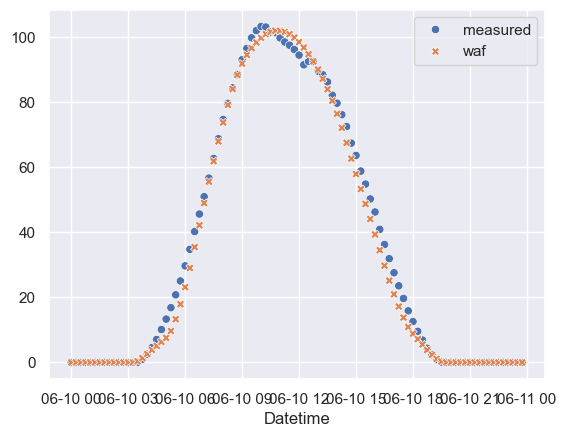

In [75]:
sns.scatterplot(df_belgium.loc['2023-06-10'])

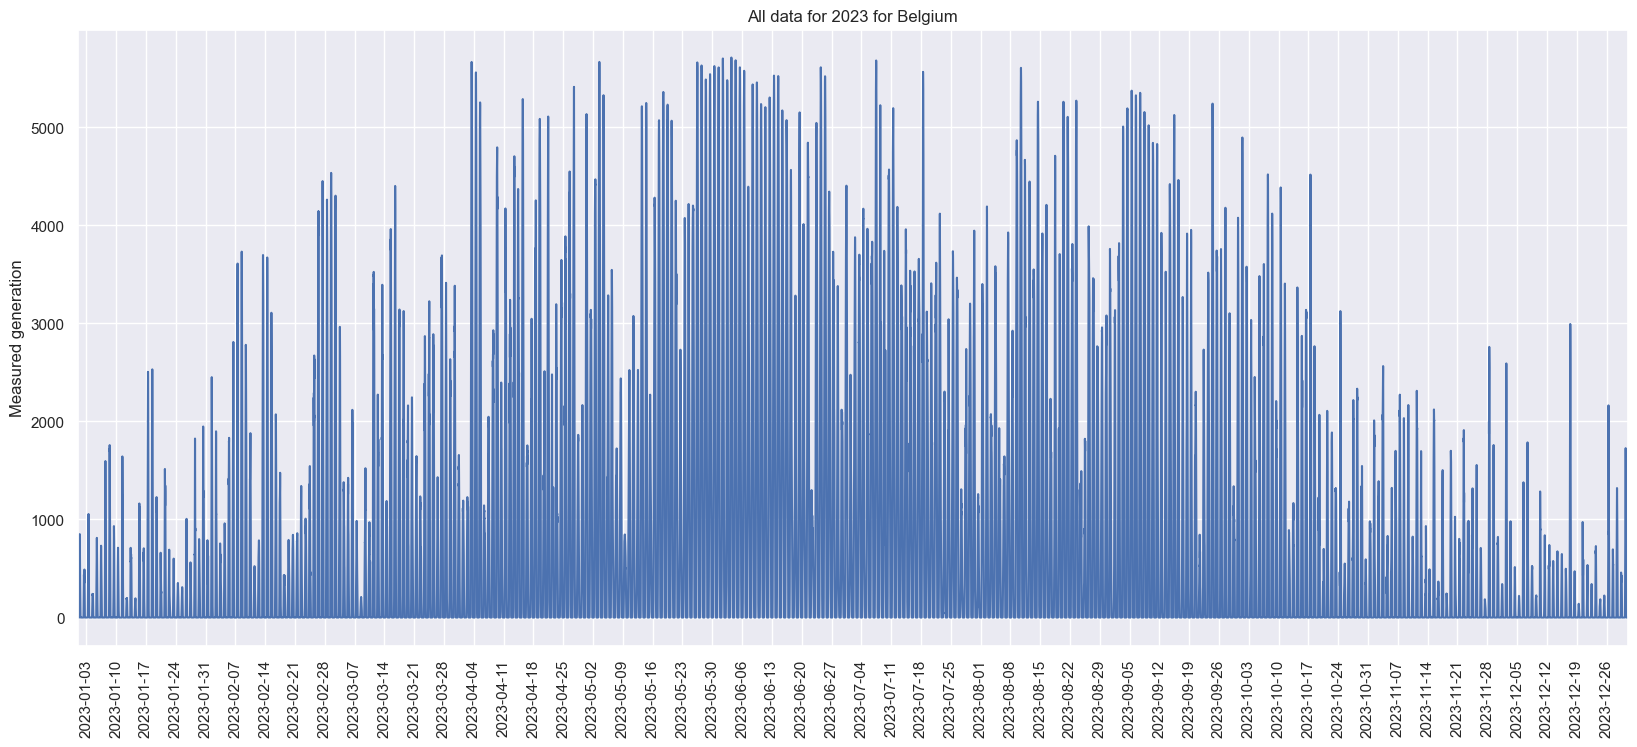

In [173]:
plt.figure(figsize=(20,8))
sns.lineplot(df_belgium['2023-01-01':'2023-12-31'].measured)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.xlabel('')
plt.ylabel('Measured generation')
plt.title('All data for 2023 for Belgium')
plt.show()

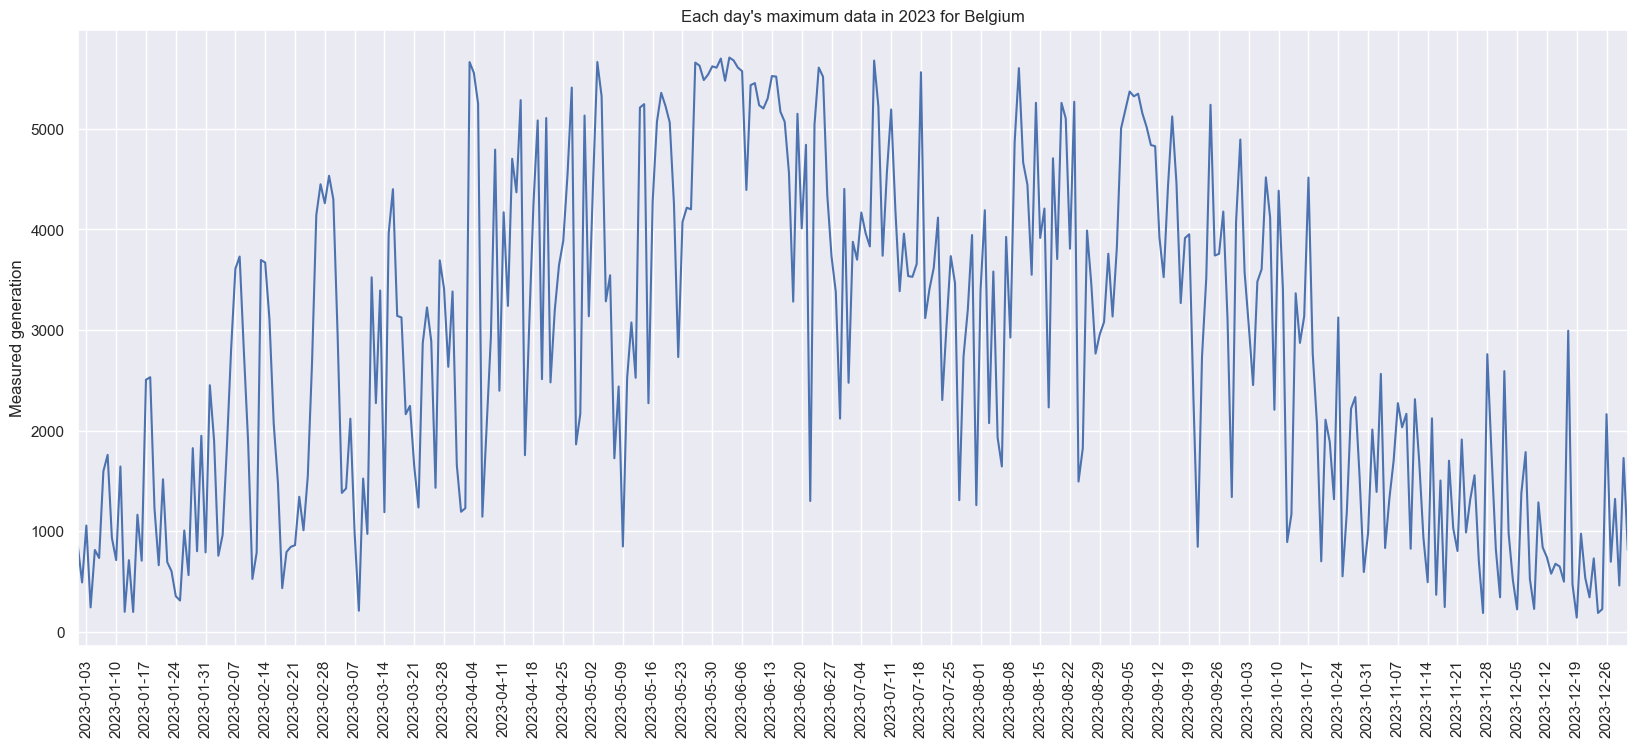

In [174]:
df_plot = df_belgium['2023-01-01':'2023-12-31'].measured.copy()
df_plot = df_plot.resample('24h').max()

plt.figure(figsize=(20,8))
sns.lineplot(df_plot)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.xlabel('')
plt.ylabel('Measured generation')
plt.title("Each day's maximum data in 2023 for Belgium")
plt.show()

## Splitting data

In [231]:
date_from = '2023-06-01'
# date_from = '2024-01-01'
duration_backward = 365
duration_forward = 7

date_from_dt = datetime.strptime(date_from, '%Y-%m-%d')
date_previous_dt = date_from_dt - timedelta(days=1)
date_previous = date_previous_dt.strftime('%Y-%m-%d')

date_week_start_dt = date_from_dt - timedelta(days=7)
date_week_start = date_week_start_dt.strftime('%Y-%m-%d')
df_week = df_belgium[date_week_start:date_previous]

date_month_start_dt = date_from_dt - timedelta(days=30)
date_month_start = date_month_start_dt.strftime('%Y-%m-%d')
df_month = df_belgium[date_month_start:date_previous]

date_start_dt = date_from_dt - timedelta(days=duration_backward)
date_start = date_start_dt.strftime('%Y-%m-%d')
df_backward = df_belgium[date_start:date_previous]

date_to_pred_dt = date_from_dt + timedelta(days=duration_forward-1)
date_to_pred = date_to_pred_dt.strftime('%Y-%m-%d')
df_forward = df_belgium[date_from:date_to_pred]
df_week_forward = df_belgium[date_week_start:date_to_pred]
df_month_forward = df_belgium[date_month_start:date_to_pred]
df_backward_forward = df_belgium[date_start:date_to_pred]

print(f'df_backward\t\t{date_start} - {date_previous}')
print(f'df_backward_forward\t{date_start} - {date_to_pred}')
print(f'df_month\t\t{date_month_start} - {date_previous}')
print(f'df_month_forward\t{date_month_start} - {date_to_pred}')
print(f'df_week\t\t\t{date_week_start} - {date_previous}')
print(f'df_week_forward\t\t{date_week_start} - {date_to_pred}')
print(f'df_forward\t\t{date_from} - {date_to_pred}')

df_backward		2022-06-01 - 2023-05-31
df_backward_forward	2022-06-01 - 2023-06-07
df_month		2023-05-02 - 2023-05-31
df_month_forward	2023-05-02 - 2023-06-07
df_week			2023-05-25 - 2023-05-31
df_week_forward		2023-05-25 - 2023-06-07
df_forward		2023-06-01 - 2023-06-07


80-100: 3840
60-80: 13440
40-60: 39936
20-40: 78040
0-20: 78152


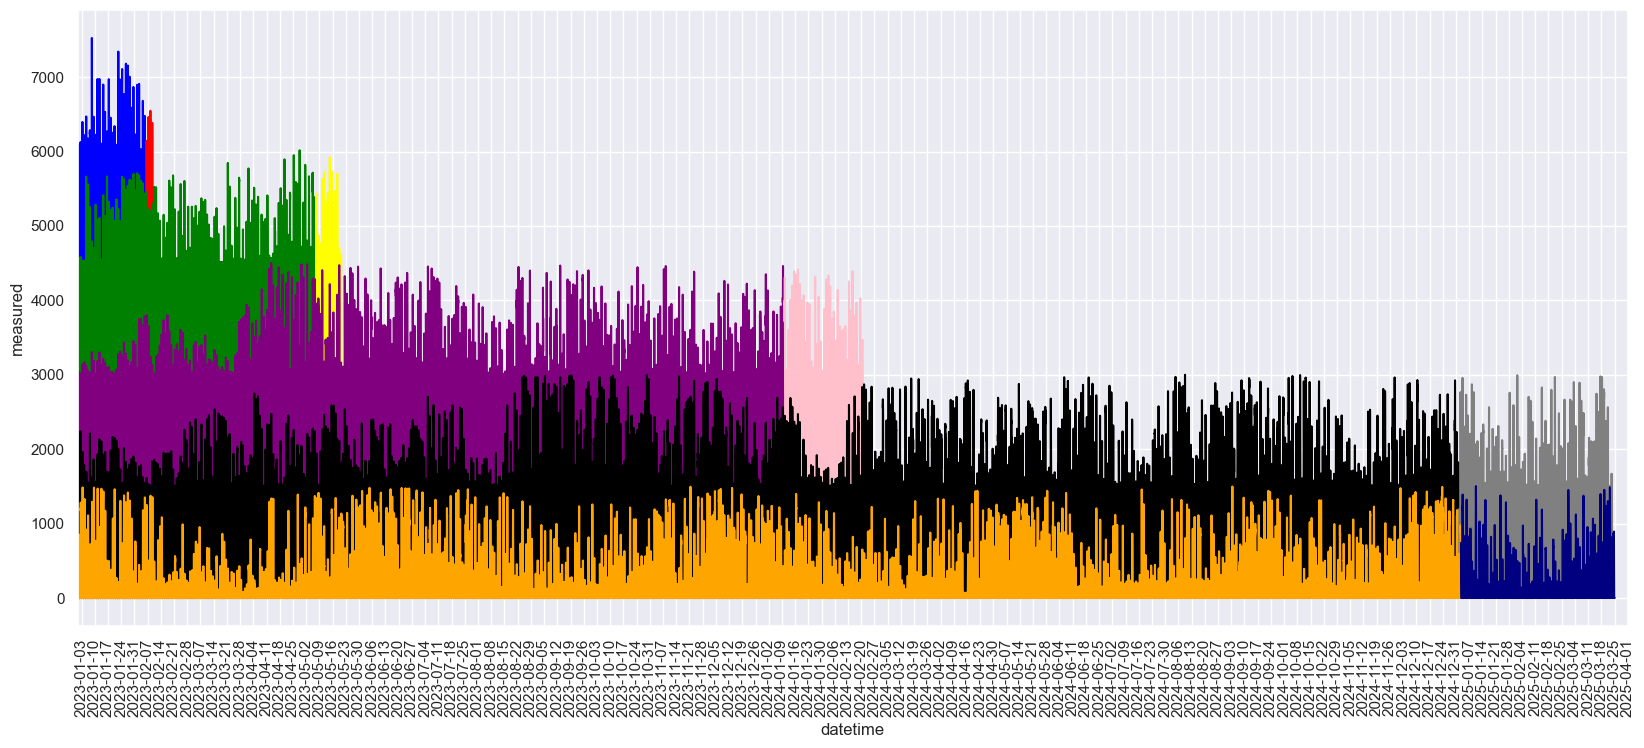

In [244]:
daily_max = df_belgium.measured.resample('D').max()
total_max = daily_max.max()

pc_80_100 = daily_max[daily_max >= total_max*0.8].index
pc_60_80 = daily_max[(daily_max >= total_max*0.6) & (daily_max < total_max*0.8)].index
pc_40_60 = daily_max[(daily_max >= total_max*0.4) & (daily_max < total_max*0.6)].index
pc_20_40 = daily_max[(daily_max >= total_max*0.2) & (daily_max < total_max*0.4)].index
pc_0_20 = daily_max[(daily_max < total_max*0.2)].index

df_pc_80_100 = df_belgium[df_belgium.index.normalize().isin(pc_80_100)]
df_pc_80_100 = df_pc_80_100.reset_index(drop=True)
df_pc_80_100['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_80_100), freq="15min")
df_pc_80_100.set_index('datetime', inplace=True)
print(f'80-100: {len(df_pc_80_100)}')
split_pc_80_100 = math.floor(len(df_pc_80_100)*0.9)
df_pc_80_100_past = df_pc_80_100.iloc[:split_pc_80_100]
df_pc_80_100_future = df_pc_80_100.iloc[split_pc_80_100:]

df_pc_60_80 = df_belgium[df_belgium.index.normalize().isin(pc_60_80)]
df_pc_60_80 = df_pc_60_80.reset_index(drop=True)
df_pc_60_80['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_60_80), freq="15min")
df_pc_60_80.set_index('datetime', inplace=True)
print(f'60-80: {len(df_pc_60_80)}')
split_pc_60_80 = math.floor(len(df_pc_60_80)*0.9)
df_pc_60_80_past = df_pc_60_80.iloc[:split_pc_60_80]
df_pc_60_80_future = df_pc_60_80.iloc[split_pc_60_80:]

df_pc_40_60 = df_belgium[df_belgium.index.normalize().isin(pc_40_60)]
df_pc_40_60 = df_pc_40_60.reset_index(drop=True)
df_pc_40_60['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_40_60), freq="15min")
df_pc_40_60.set_index('datetime', inplace=True)
print(f'40-60: {len(df_pc_40_60)}')
split_pc_40_60 = math.floor(len(df_pc_40_60)*0.9)
df_pc_40_60_past = df_pc_40_60.iloc[:split_pc_40_60]
df_pc_40_60_future = df_pc_40_60.iloc[split_pc_40_60:]

df_pc_20_40 = df_belgium[df_belgium.index.normalize().isin(pc_20_40)]
df_pc_20_40 = df_pc_20_40.reset_index(drop=True)
df_pc_20_40['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_20_40), freq="15min")
df_pc_20_40.set_index('datetime', inplace=True)
print(f'20-40: {len(df_pc_20_40)}')
split_pc_20_40 = math.floor(len(df_pc_20_40)*0.9)
df_pc_20_40_past = df_pc_20_40.iloc[:split_pc_20_40]
df_pc_20_40_future = df_pc_20_40.iloc[split_pc_20_40:]

df_pc_0_20 = df_belgium[df_belgium.index.normalize().isin(pc_0_20)]
df_pc_0_20 = df_pc_0_20.reset_index(drop=True)
df_pc_0_20['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_0_20), freq="15min")
df_pc_0_20.set_index('datetime', inplace=True)
print(f'0-20: {len(df_pc_0_20)}')
split_pc_0_20 = math.floor(len(df_pc_0_20)*0.9)
df_pc_0_20_past = df_pc_0_20.iloc[:split_pc_0_20]
df_pc_0_20_future = df_pc_0_20.iloc[split_pc_0_20:]

plt.figure(figsize=(20,8))
sns.lineplot(df_pc_80_100_past.measured, color='blue')
sns.lineplot(df_pc_80_100_future.measured, color='red')
sns.lineplot(df_pc_60_80_past.measured, color='green')
sns.lineplot(df_pc_60_80_future.measured, color='yellow')
sns.lineplot(df_pc_40_60_past.measured, color='purple')
sns.lineplot(df_pc_40_60_future.measured, color='pink')
sns.lineplot(df_pc_20_40_past.measured, color='black')
sns.lineplot(df_pc_20_40_future.measured, color='grey')
sns.lineplot(df_pc_0_20_past.measured, color='orange')
sns.lineplot(df_pc_0_20_future.measured, color='navy')
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2025-04-01'))
plt.show()

80-100: 3744
60-80: 13440
40-60: 39936
20-40: 78040
0-20: 78152


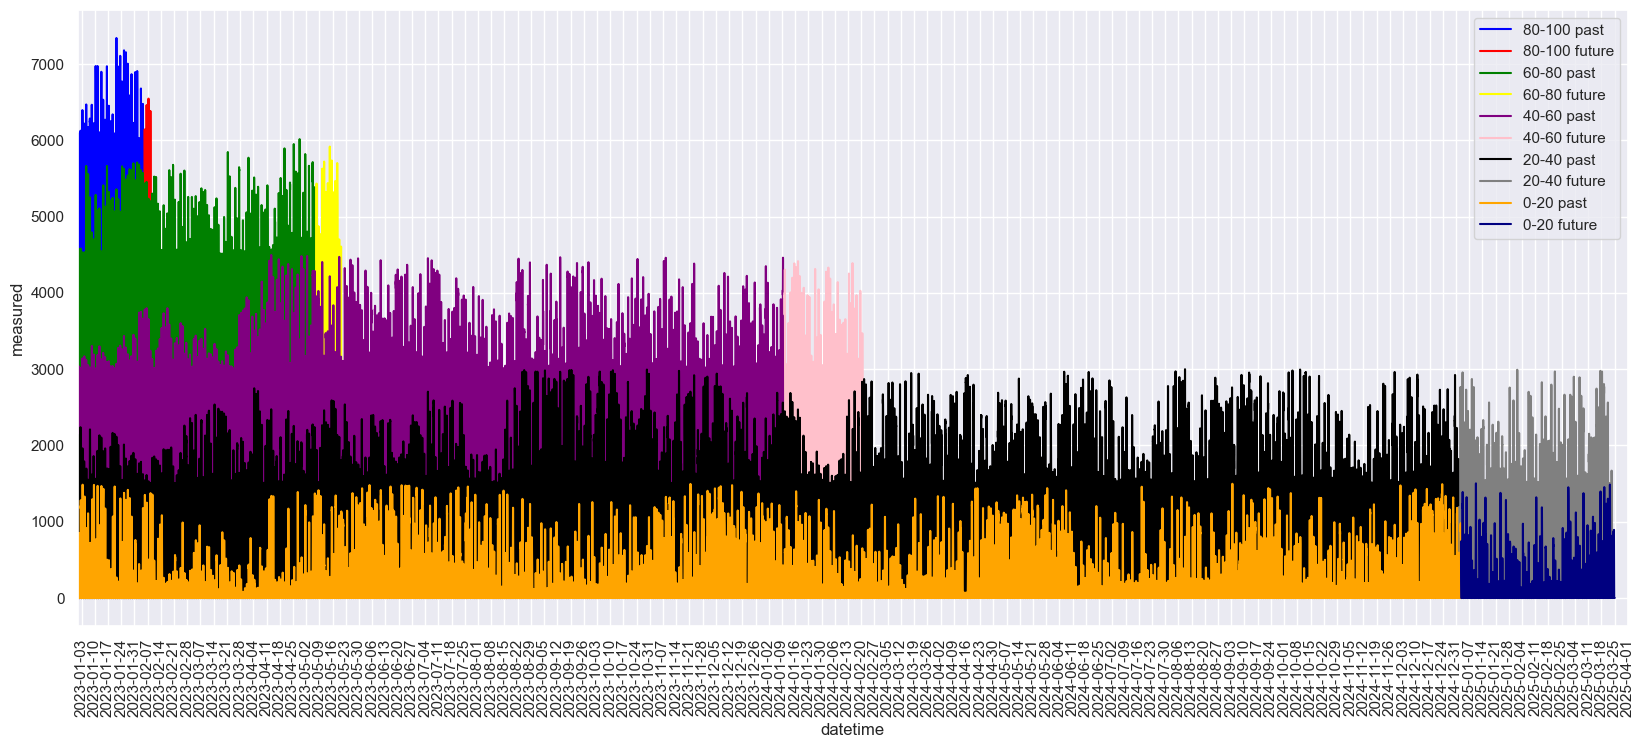

In [255]:
def process_data(df, indices, start_date, freq="15min"):
    df_filtered = df[df.index.normalize().isin(indices)].reset_index(drop=True)
    df_filtered['datetime'] = pd.date_range(start=start_date, periods=len(df_filtered), freq=freq)
    df_filtered.set_index('datetime', inplace=True)
    split_index = math.floor(len(df_filtered) * 0.9)
    return df_filtered.iloc[:split_index], df_filtered.iloc[split_index:]

daily_max = df_belgium.measured.resample('D').max()
total_max = daily_max.max()

ranges = {
    '80-100': (0.8, 1.0),
    '60-80': (0.6, 0.8),
    '40-60': (0.4, 0.6),
    '20-40': (0.2, 0.4),
    '0-20': (0.0, 0.2)
}

data_segments = {}
for label, (low, high) in ranges.items():
    indices = daily_max[(daily_max >= total_max * low) & (daily_max < total_max * high)].index
    past, future = process_data(df_belgium, indices, start_date="2023-01-01")
    data_segments[label] = (past, future)
    print(f'{label}: {len(past) + len(future)}')

plt.figure(figsize=(20, 8))
past_colors = ['blue', 'green', 'purple', 'black', 'orange']
future_colors = ['red', 'yellow', 'pink', 'grey', 'navy']

for (label, (past, future)), past_color, future_color in zip(data_segments.items(), past_colors, future_colors):
    sns.lineplot(past.measured, color=past_color, label=f'{label} past')
    sns.lineplot(future.measured, color=future_color, label=f'{label} future')

plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2025-04-01'))
plt.legend()
plt.show()

In [ ]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df_belgium.index, y=df_belgium.Measured, mode='lines+markers', name='Value'))
# fig.show()

## Model imports and predictions

In [15]:
model_auto_daily_1h = pickle.load(open('ods032_model_auto_daily_1h.pkl','rb'))
model_auto_daily_2h = pickle.load(open('ods032_model_auto_daily_2h.pkl','rb'))
model_auto_daily_4h = pickle.load(open('ods032_model_auto_daily_4h.pkl','rb'))
model_auto_weekly_1h = pickle.load(open('ods032_model_auto_weekly_1h.pkl','rb'))
model_auto_weekly_2h = pickle.load(open('ods032_model_auto_weekly_2h.pkl','rb'))
model_auto_weekly_4h = pickle.load(open('ods032_model_auto_weekly_4h.pkl','rb'))

In [16]:
df_auto_daily_pred_1h = pd.DataFrame(model_auto_daily_1h.predict(n_periods=24*duration_forward))
df_auto_daily_pred_1h = df_auto_daily_pred_1h.clip(lower=0)
df_auto_daily_pred_2h = pd.DataFrame(model_auto_daily_2h.predict(n_periods=12*duration_forward))
df_auto_daily_pred_2h = df_auto_daily_pred_2h.clip(lower=0)
df_auto_daily_pred_4h = pd.DataFrame(model_auto_daily_4h.predict(n_periods=6*duration_forward))
df_auto_daily_pred_4h = df_auto_daily_pred_4h.clip(lower=0)
df_auto_weekly_pred_1h = pd.DataFrame(model_auto_weekly_1h.predict(n_periods=24*duration_forward))
df_auto_weekly_pred_1h = df_auto_weekly_pred_1h.clip(lower=0)
df_auto_weekly_pred_2h = pd.DataFrame(model_auto_weekly_2h.predict(n_periods=12*duration_forward))
df_auto_weekly_pred_2h = df_auto_weekly_pred_2h.clip(lower=0)
df_auto_weekly_pred_4h = pd.DataFrame(model_auto_weekly_4h.predict(n_periods=6*duration_forward))
df_auto_weekly_pred_4h = df_auto_weekly_pred_4h.clip(lower=0)

## Modelling

In [226]:
def resample_h(df, h):
    r = f'{str(h)}h'
    s = int(96/4/int(h))
    return df.resample(r).mean(), s, r

def resample_m(df, m):
    r = f'{str(60*m)}min'
    s = int(96/4/m)
    return df.resample(r).mean(), s, r

def plot_pred(df_pred):
    plt.figure(figsize=(20,8))
    sns.lineplot(df_forward.measured, color = 'black', label='Actual')
    # sns.lineplot(df_f.measured, color = 'black', label='Actual, sampled')
    sns.lineplot(df_forward.waf, color='grey', alpha=0.5, label='Their week-ahead forecast')
    # sns.lineplot(df_f.waf, color='grey', alpha=0.5, label='Their week-ahead forecast, sampled')
    sns.lineplot(df_pred[0], color = 'red', alpha=0.5, label='My forecast')
    plt.legend()
    plt.show()

def plot_input(df_in):
    plt.figure(figsize=(20,8))
    sns.lineplot(df_in.measured, color = 'black', label='Actual')
    plt.show()

def forecast_stats(df):
    df = df.copy()
    df['error'] = df.measured - df.waf
    print(f'Mean\t\t{round(df.waf.mean(),2)}')
    print(f'Median\t\t{round(df.waf.median(),2)}')
    print(f'Mode\t\t{round(df.waf.mode()[0],2)}')
    print(f'Std Dev\t\t{round(df.waf.std(),2)}')
    print(f'Mean Error\t{round(df.error.mean(),2)}')
    print(f'Median Error\t{round(df.error.median(),2)}')
    print(f'Mode Error\t{round(df.error.mode()[0],2)}')
    print(f'Error Std Dev\t{round(df.error.std(),2)}')
    print(f'Max Error\t{round(abs(df.error).max(),2)}')
    print(f'MAE\t\t{round(mean_absolute_error(df.measured, df.waf),2)}')
    print(f'MSE\t\t{round(mean_squared_error(df.measured, df.waf),2)}')
    print(f'RMSE\t\t{round(np.sqrt(mean_squared_error(df.measured, df.waf)),2)}')
    mape = np.where(df.measured != 0, np.abs(df.error / df.measured) * 100, 0)
    print(f'MA%E\t\t{round(np.mean(mape), 2)}')
    print(f'R²\t\t{round(r2_score(df.measured, df.waf),2)}')

def jgstats(df_pred, df_f):
    df = pd.concat([df_f, df_pred], axis=1)
    df = df.bfill().ffill()
    df = df.drop(['waf'], axis=1)
    df = df.rename(columns={0:'prediction'})
    df['error'] = df.measured - df.prediction
    print(f'Mean\t\t{round(df.prediction.mean(),2)}')
    print(f'Median\t\t{round(df.prediction.median(),2)}')
    print(f'Mode\t\t{round(df.prediction.mode()[0],2)}')
    print(f'Std Dev\t\t{round(df.prediction.std(),2)}')
    print(f'Mean Error\t{round(df.error.mean(),2)}')
    print(f'Median Error\t{round(df.error.median(),2)}')
    print(f'Mode Error\t{round(df.error.mode()[0],2)}')
    print(f'Error Std Dev\t{round(df.error.std(),2)}')
    print(f'Max Error\t{round(abs(df.error).max(),2)}')
    print(f'MAE\t\t{round(mean_absolute_error(df.measured, df.prediction),2)}')
    print(f'MSE\t\t{round(mean_squared_error(df.measured, df.prediction),2)}')
    print(f'RMSE\t\t{round(np.sqrt(mean_squared_error(df.measured, df.prediction)),2)}')
    mape = np.where(df.measured != 0, np.abs(df.error / df.measured) * 100, 0)
    print(f'MA%E\t\t{round(np.mean(mape), 2)}')
    print(f'R²\t\t{round(r2_score(df.measured, df.prediction),2)}')

def run_model(df_in, df_a, m, s=0, trace=False, stats=False, plot=True, save=False, name=''):
    if s == 0:
        df = df_in
        daily_samples = 96
        df_f = df_forward
        daily_samples_f = 96
        r = 'N/A'
    elif s > 0 and s < 1:
        df, daily_samples, r = resample_m(df_in, s)
        df_f, daily_samples_f, _ = resample_m(df_forward, s)
        df_a, _, _ = resample_m(df_a, s)
    else:
        df, daily_samples, r = resample_h(df_in, s)
        df_f, daily_samples_f, _ = resample_h(df_forward, s)
        df_a, _, _ = resample_h(df_a, s)
    # m = daily_samples
    pred_periods = daily_samples_f*duration_forward
    print(f'{int(len(df)/daily_samples)} days of data, from {df.index[0].date()} to {df.index[-1].date()}\nsampled at {r}, giving {len(df)} values ({daily_samples}/day)\nseasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({duration_forward} days), until {df_f.index[-1].date()}\n')

    plot_input(df)

    if trace:
        model_auto = auto_arima(df.measured, seasonal=True, m=int(m), stepwise=True, trace=True) # jobs=-1
    else:
        model_auto = auto_arima(df.measured, seasonal=True, m=int(m), stepwise=True) # jobs=-1
    
    df_auto_pred = pd.DataFrame(model_auto.predict(n_periods=pred_periods))
    df_auto_pred = df_auto_pred.clip(lower=0)
    df_auto_pred.index = df_auto_pred.index + pd.Timedelta(hours=s/2) # to centralise samples

    if display:
        print()
        display(jgstats(df_auto_pred, df_f))

    if plot:
        plot_pred(df_auto_pred)

    if save:
        with open(f'ods032_model_auto_{name}.pkl', 'wb') as f:
            pickle.dump(model_auto, f)

    return model_auto, df_auto_pred

7 days of data, from 2023-05-25 to 2023-05-31
sampled at 1h, giving 168 values (24/day)
seasonal period of 24 (1 days)
with 168 predictons (7 days), until 2023-06-07



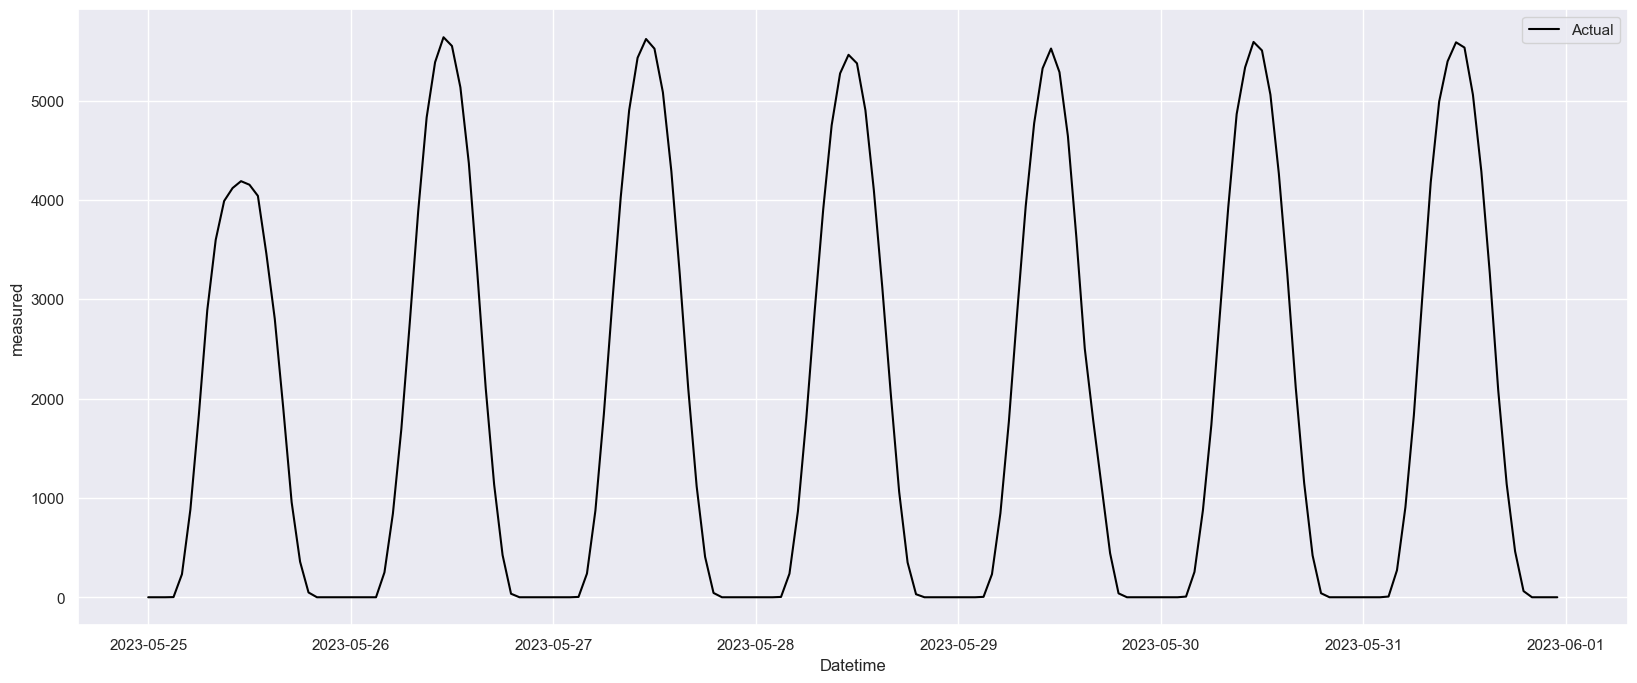

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[24] intercept   : AIC=1685.057, Time=3.28 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=2029.542, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=1785.630, Time=1.00 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=2034.225, Time=0.04 sec
 ARIMA(2,0,2)(0,1,1)[24] intercept   : AIC=1686.031, Time=2.39 sec
 ARIMA(2,0,2)(1,1,0)[24] intercept   : AIC=1687.856, Time=2.23 sec
 ARIMA(2,0,2)(2,1,1)[24] intercept   : AIC=1686.355, Time=7.48 sec
 ARIMA(2,0,2)(1,1,2)[24] intercept   : AIC=1685.984, Time=8.21 sec
 ARIMA(2,0,2)(0,1,0)[24] intercept   : AIC=1689.013, Time=0.64 sec
 ARIMA(2,0,2)(0,1,2)[24] intercept   : AIC=1684.183, Time=5.43 sec
 ARIMA(1,0,2)(0,1,2)[24] intercept   : AIC=1688.726, Time=4.34 sec
 ARIMA(2,0,1)(0,1,2)[24] intercept   : AIC=1682.188, Time=5.21 sec
 ARIMA(2,0,1)(0,1,1)[24] intercept   : AIC=1684.036, Time=1.88 sec
 ARIMA(2,0,1)(1,1,2)[24]

None

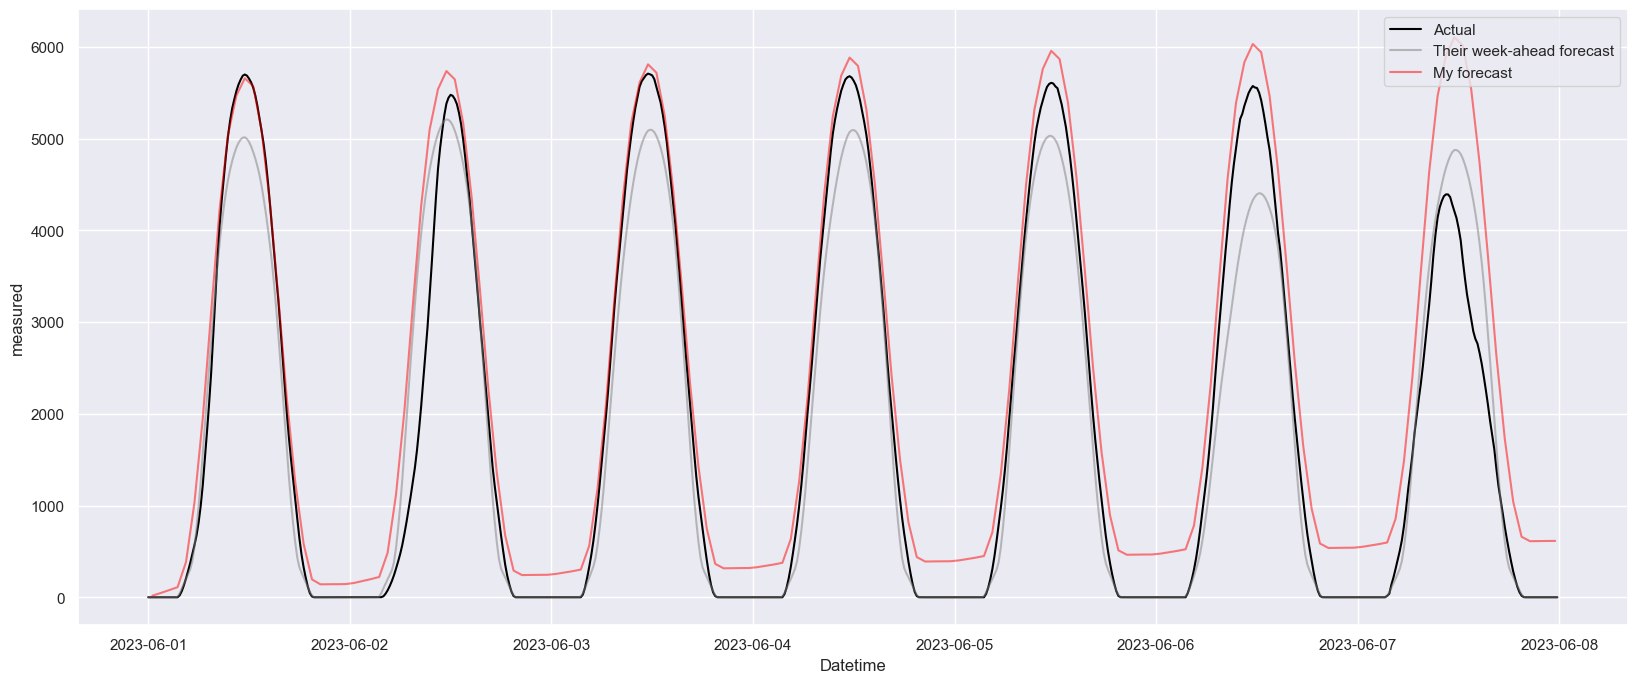

In [249]:
model, pred = run_model(df_week, df_week_forward, m=24, s=1, trace=True, stats=True, plot=True, save=False, name='')

## Measuring best models

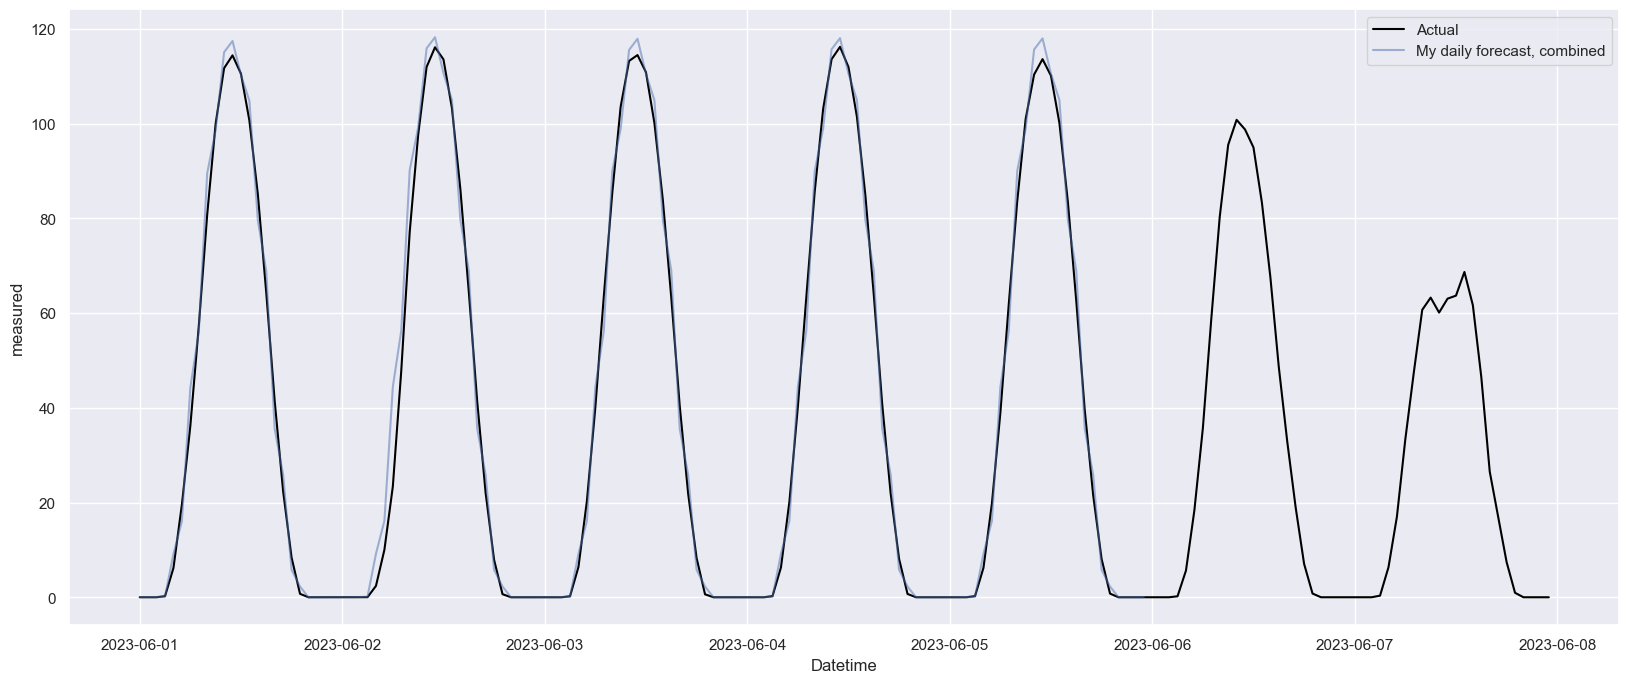

Mean		40.93
Median		21.01
Mode		0.0
Std Dev		44.33
Mean Error	-0.86
Median Error	-0.01
Mode Error	0.0
Error Std Dev	4.07
Max Error	21.03
MAE		2.81
MSE		17.18
RMSE		4.14
MA%E		28.82
R²		0.99


In [103]:
# convert all prediction dfs to hourly
df_auto_daily_pred_2h_temp, _, _ = resample_h(df_auto_daily_pred_2h,1)
df_auto_daily_pred_2h_temp = df_auto_daily_pred_2h_temp.ffill().bfill()

# combine with weights
df_auto_pred_combined = pd.DataFrame(0.5*df_auto_daily_pred_2h_temp + 0.5*df_auto_daily_pred_1h)
df_auto_pred_combined = df_auto_pred_combined.clip(lower=0)

plt.figure(figsize=(20,8))
sns.lineplot(df_forward.measured.iloc[:96*5], color = 'black', label='Actual')
# sns.lineplot(df_forward.waf, color='green', alpha=0.5, label='Their week-ahead forecast')
# sns.lineplot(df_auto_pred_4h[0], color = 'pink', alpha=0.5, label='My 151d forecast, 4h')
# sns.lineplot(df_auto_weekly_pred_4h[0], alpha=0.5, label='My weekly forecast, 4h') # terrible
# sns.lineplot(df_auto_weekly_pred_2h[0], alpha=0.5, label='My weekly forecast, 2h') # terrible
# sns.lineplot(df_auto_weekly_pred_1h[0], alpha=0.5, label='My weekly forecast, 1h') # terrible
# sns.lineplot(df_auto_daily_pred_4h[0], alpha=0.5, label='My daily forecast, 4h')
# sns.lineplot(df_auto_daily_pred_2h[0], alpha=0.5, label='My daily forecast, 2h')
# sns.lineplot(df_auto_daily_pred_1h[0], alpha=0.5, label='My daily forecast, 1h')
sns.lineplot(df_auto_pred_combined[0].iloc[:120], alpha=0.5, label='My daily forecast, combined')
plt.legend()
plt.show()

result = pd.concat([df_forward.resample('1h').mean().iloc[:120], df_auto_pred_combined.iloc[:120]], axis=1)
result = result.bfill()
result = result.ffill()
result = result.rename(columns={0:'prediction'})
result['error_mine'] = result.measured - result.prediction
result['error_waf'] = result.measured - result.waf
print(f'Mean\t\t{round(result.prediction.mean(),2)}')
print(f'Median\t\t{round(result.prediction.median(),2)}')
print(f'Mode\t\t{round(result.prediction.mode()[0],2)}')
print(f'Std Dev\t\t{round(result.prediction.std(),2)}')
print(f'Mean Error\t{round(result.error_mine.mean(),2)}')
print(f'Median Error\t{round(result.error_mine.median(),2)}')
print(f'Mode Error\t{round(result.error_mine.mode()[0],2)}')
print(f'Error Std Dev\t{round(result.error_mine.std(),2)}')
print(f'Max Error\t{round(abs(result.error_mine).max(),2)}')
print(f'MAE\t\t{round(mean_absolute_error(result.measured, result.prediction),2)}')
print(f'MSE\t\t{round(mean_squared_error(result.measured, result.prediction),2)}')
print(f'RMSE\t\t{round(np.sqrt(mean_squared_error(result.measured, result.prediction)),2)}')
mape = np.where(result.measured != 0, np.abs(result.error_mine / result.measured) * 100, 0)
print(f'MA%E\t\t{round(np.mean(mape), 2)}')
print(f'R²\t\t{round(r2_score(result.measured, result.prediction),2)}')

## SARIMAX single

In [222]:
# model = SARIMAX(df_filtered.asfreq('15min'), order=(3,0,2), seasonal_order=(1,0,0,96))
# model_fit = model.fit()
# model_fit.summary()
# df_sarimax_pred = model_fit.get_forecast(steps=96).predicted_mean
# df_sarimax_pred = pd.DataFrame(df_sarimax_pred, columns=['predicted_mean'])
# mae = mean_absolute_error(df_sampled_only_pred.measured, df_sarimax_pred)
# mse = mean_squared_error(df_sampled_only_pred.measured, df_sarimax_pred)
# rmse = np.sqrt(mse)
# mape = np.mean(np.abs((df_sampled_only_pred.measured - df_sarimax_pred) / df_sampled_only_pred.measured)) * 100
# print(f'Mean Absolute Error (MAE): {mae}')
# print(f'Mean Squared Error (MSE): {mse}')
# print(f'Root Mean Squared Error (RMSE): {rmse}')
# print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

# API

In [223]:
# df = pd.DataFrame()

# year = 2023
# for month in range(1,13):
#   for day in range(1,32):
#       url = f'https://opendata.elia.be/api/explore/v2.1/catalog/datasets/ods032/records?select=datetime%2C%20measured&where=region%20%3D%20%27Luxembourg%27&limit=100&refine=datetime%3A{year}-{month:02d}-{day:02d}'
#       r = requests.get(url)
#       if r.status_code == 200:
#           temp_df = pd.DataFrame(r.json()['results'])
#           print(f'Done {day}/{month}/{year}')
#           df = pd.concat([df, temp_df], ignore_index=True)
#       else:
#           print(f'{day}/{month}/{year}: {r.status_code}')

# df.datetime = pd.to_datetime(df.datetime, utc=True)
# df.datetime = df.datetime.dt.tz_localize(None)
# # df = df.rename(columns={'datetime':'ds','measured':'y'})
# df = df.bfill()
# df